In [1]:
!pip install --upgrade fastai
!pip install --upgrade wandb
!pip install --upgrade torch
!pip install git+https://github.com/tmabraham/UPIT.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 533.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
!pip install upit


In [3]:
from upit.data.unpaired import *
from upit.models.cyclegan import *
from upit.train.cyclegan import *
from upit.inference.cyclegan import *
from upit.metrics import *
from upit.tracking.wandb import *
from fastai.vision.all import *
import wandb

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [8]:
photo2monet = Path('./gan-getting-started')
trainA_path = photo2monet/'photo_jpg'
trainB_path = photo2monet/'monet_jpg'
print(f"There are {len(trainA_path.ls())} photos")
print(f"There are {len(trainB_path.ls())} Monet paintings")

There are 7038 photos
There are 300 Monet paintings


In [9]:
dls = get_dls(trainA_path, trainB_path,load_size=256,crop_size=256)

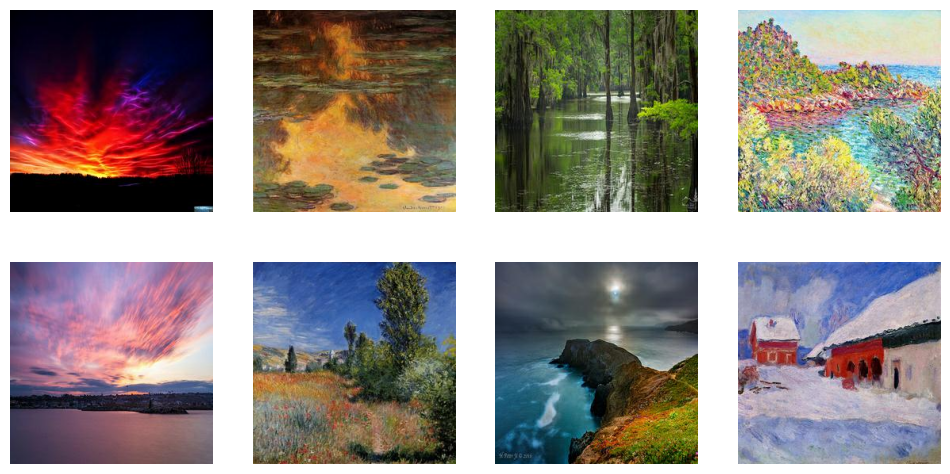

In [10]:
dls.show_batch()

In [11]:
cycle_gan = CycleGAN(3,3,64,gen_blocks=3)

In [12]:
learn = cycle_learner(dls, cycle_gan,opt_func=partial(Adam,mom=0.5,sqr_mom=0.999),show_img_interval=8)

In [ ]:
learn.fit_flat_lin(7,7,2e-4)

epoch,train_loss,id_loss_A,id_loss_B,gen_loss_A,gen_loss_B,cyc_loss_A,cyc_loss_B,D_A_loss,D_B_loss,time


epoch,train_loss,id_loss_A,id_loss_B,gen_loss_A,gen_loss_B,cyc_loss_A,cyc_loss_B,D_A_loss,D_B_loss,time
